In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Get data 
df_reg = pd.read_csv('data/model_data_regression.csv', index_col=0)
df_class = pd.read_csv('data/model_data_classification.csv', index_col=0)

In [4]:
# Get features and target for regression and classification
target = 'ninds_total_cost'

X_reg = df_reg.drop([target], axis=1)
features_reg = X_reg.columns
y_reg = df_reg[target]

X_class = df_class.drop([target], axis=1)
features_class = X_class.columns
y_class = df_class[target]

## lasso regression

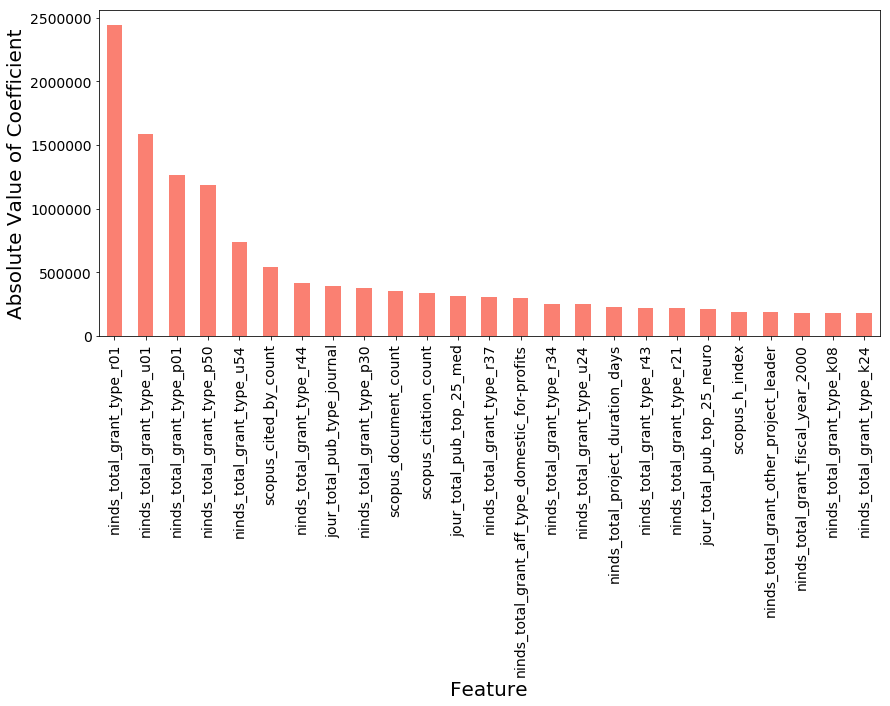

In [5]:
# Lasso regression
pipe_lasso = Pipeline([('StandardScaler', StandardScaler()), ('LassoRegression', Lasso(random_state=0))])

pipe_lasso.fit(X_reg, y_reg)

features_lasso = X_reg.columns
coefs_lasso = pipe_lasso.named_steps['LassoRegression'].coef_
important_features_lasso = []
for i in range(0, len(features_lasso)):
    important_features_lasso.append([features_lasso[i], np.absolute(coefs_lasso[i])])

important_features_lasso = sorted(important_features_lasso, key=lambda x: x[1], reverse=True)
important_features_lasso = pd.DataFrame(important_features_lasso)[0:25]

ax=plt.subplot()
important_features_lasso.plot(x=0, y=1, kind='bar', legend=False, figsize=(14,6), color='salmon', fontsize=14, rot=90, ax=ax)
ax.set_xlabel('Feature', fontsize=20)
ax.set_ylabel('Absolute Value of Coefficient', fontsize=20)
plt.show()

In [6]:
# Hyperparameter tune lasso regression
clfs = {'lr': Lasso(random_state=0)}

pipe_clfs = {}
for name, clf in clfs.items():
    pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), ('clf', clf)])

param_grids = {}
param_grid = [{'clf__alpha': [10 ** i for i in range(-5, 1)]}]
param_grids['lr'] = param_grid

best_score_param_estimators = []
for name in pipe_clfs.keys():
    gs = GridSearchCV(estimator=pipe_clfs[name],
                      param_grid=param_grids[name],
                      scoring='neg_mean_squared_error',
                      n_jobs=-1,
                      cv=StratifiedKFold(n_splits=10,
                                         shuffle=True,
                                         random_state=0))
    gs = gs.fit(X_reg, y_reg)
    best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)
for best_score_param_estimator in best_score_param_estimators:
    print([best_score_param_estimator[0], best_score_param_estimator[1], type(best_score_param_estimator[2].named_steps['clf'])], end='\n\n')

[-13063306498151.744, {'clf__alpha': 1}, <class 'sklearn.linear_model.coordinate_descent.Lasso'>]



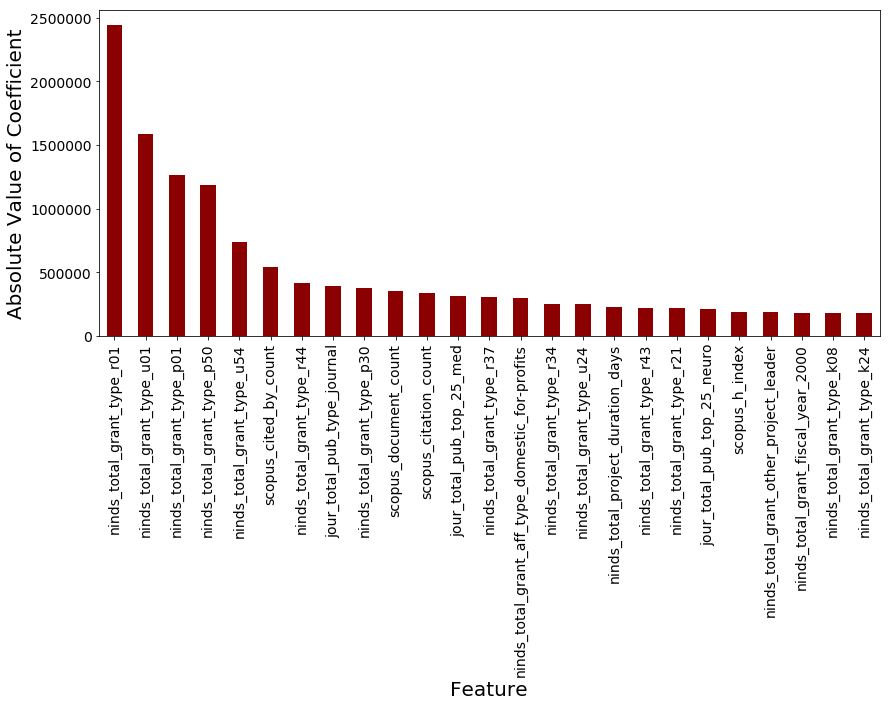

In [7]:
# Plot feature importance based on hyperparameter tuned lasso regression
pipe_hyp_lasso = Pipeline([('StandardScaler', StandardScaler()), ('LassoRegression', Lasso(alpha=1, random_state=0))])

pipe_hyp_lasso.fit(X_reg, y_reg)

pipe_hyp_lasso.fit(X_reg, y_reg)

features_hyp_lasso = X_reg.columns
coefs_hyp_lasso = pipe_hyp_lasso.named_steps['LassoRegression'].coef_
important_features_hyp_lasso = []
for i in range(0, len(features_hyp_lasso)):
    important_features_hyp_lasso.append([features_hyp_lasso[i], np.absolute(coefs_hyp_lasso[i])])

important_features_hyp_lasso = sorted(important_features_hyp_lasso, key=lambda x: x[1], reverse=True)
important_features_hyp_lasso = pd.DataFrame(important_features_hyp_lasso)[0:25]

ax=plt.subplot()
important_features_hyp_lasso.plot(x=0, y=1, kind='bar', legend=False, figsize=(14,6), color='darkred', fontsize=14, rot=90, ax=ax)
ax.set_xlabel('Feature', fontsize=20)
ax.set_ylabel('Absolute Value of Coefficient', fontsize=20)
plt.show()

## random forest regressor

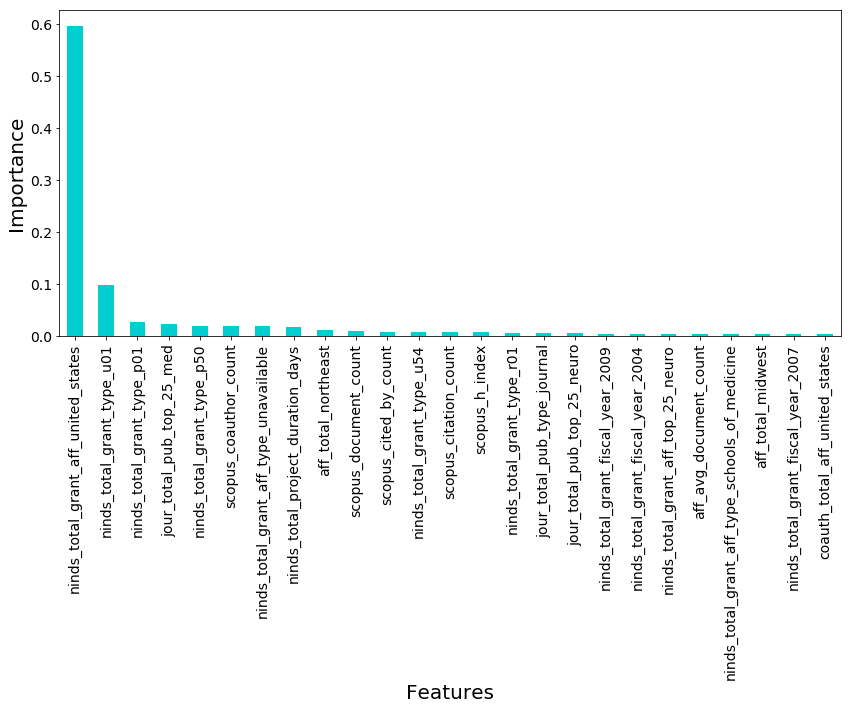

In [8]:
# Random forest regressor
pipe_rfr = Pipeline([('StandardScaler', StandardScaler()), ('RandomForestRegressor', RandomForestRegressor(random_state=0))])

pipe_rfr.fit(X_reg, y_reg)

important_features_rfr = pd.Series(pipe_rfr.named_steps['RandomForestRegressor'].feature_importances_, features_reg)
important_features_rfr = important_features_rfr.sort_values(ascending=False)[0:25]

ax=plt.subplot()
important_features_rfr.plot(x='Features', y='Importance', kind='bar', figsize=(14,6), color='darkturquoise', fontsize=14, rot=90, ax=ax)
ax.set_xlabel('Features', fontsize=20)
ax.set_ylabel('Importance', fontsize=20)
plt.show()

In [9]:
# Hyperparameter tune random forest regressor
clfs = {'rfr': RandomForestRegressor(random_state=0)}

pipe_clfs = {}
for name, clf in clfs.items():
    pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), ('clf', clf)])

param_grids = {}
param_grid = [{'clf__n_estimators': [2, 10, 30],
               'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}]
param_grids['rfr'] = param_grid

best_score_param_estimators = []
for name in pipe_clfs.keys():
    gs = GridSearchCV(estimator=pipe_clfs[name],
                      param_grid=param_grids[name],
                      scoring='neg_mean_squared_error',
                      n_jobs=-1,
                      cv=StratifiedKFold(n_splits=10,
                                         shuffle=True,
                                         random_state=0))
    gs = gs.fit(X_reg, y_reg)
    best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)
for best_score_param_estimator in best_score_param_estimators:
    print([best_score_param_estimator[0], best_score_param_estimator[1], type(best_score_param_estimator[2].named_steps['clf'])], end='\n\n')

[-20796360639708.797, {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 10}, <class 'sklearn.ensemble.forest.RandomForestRegressor'>]



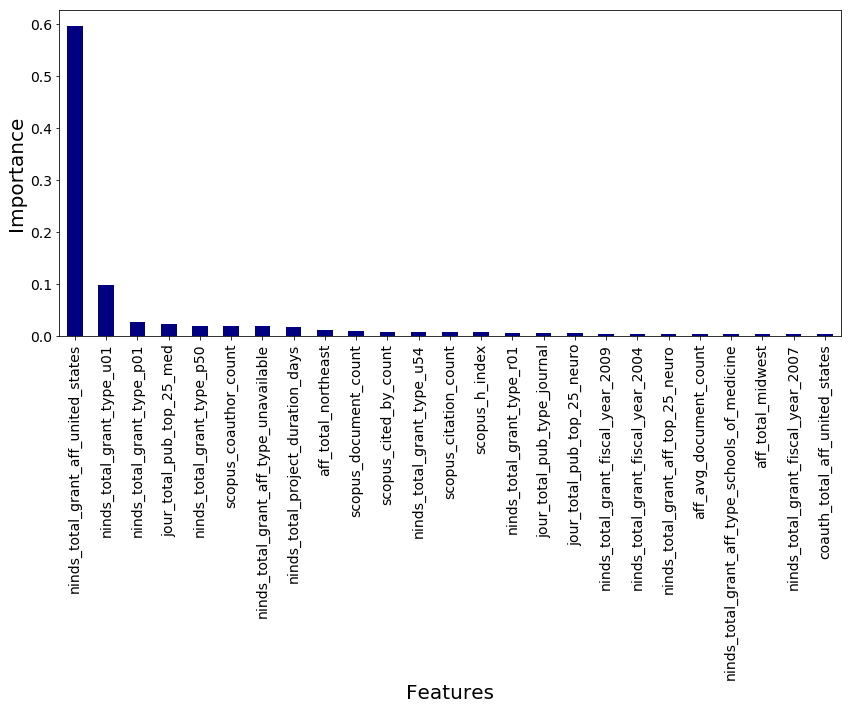

In [10]:
# Plot feature importance based on hyperparameter tuned random forest regressor
pipe_hyp_rfr = Pipeline([('StandardScaler', StandardScaler()), 
                         ('RandomForestRegressor', RandomForestRegressor(min_samples_leaf=1, 
                                                                         min_samples_split=2, 
                                                                         n_estimators=10,
                                                                         random_state=0))])

pipe_hyp_rfr.fit(X_reg, y_reg)

important_features_hyp_rfr = pd.Series(pipe_hyp_rfr.named_steps['RandomForestRegressor'].feature_importances_, features_reg)
important_features_hyp_rfr = important_features_hyp_rfr.sort_values(ascending=False)[0:25]

ax=plt.subplot()
important_features_hyp_rfr.plot(x='Feature', y='Importance', kind='bar', figsize=(14,6), color='navy', fontsize=14, rot=90, ax=ax)
ax.set_xlabel('Features', fontsize=20)
ax.set_ylabel('Importance', fontsize=20)
plt.show()

## random forest classifier

In [11]:
# Random over sampler
ros = RandomOverSampler(random_state=0)
X_class, y_class = ros.fit_sample(X_class, y_class)

pd.DataFrame(data=y_class, columns=[target])[target].value_counts()

3.0    7172
5.0    7172
4.0    7172
2.0    7172
1.0    7172
Name: ninds_total_cost, dtype: int64

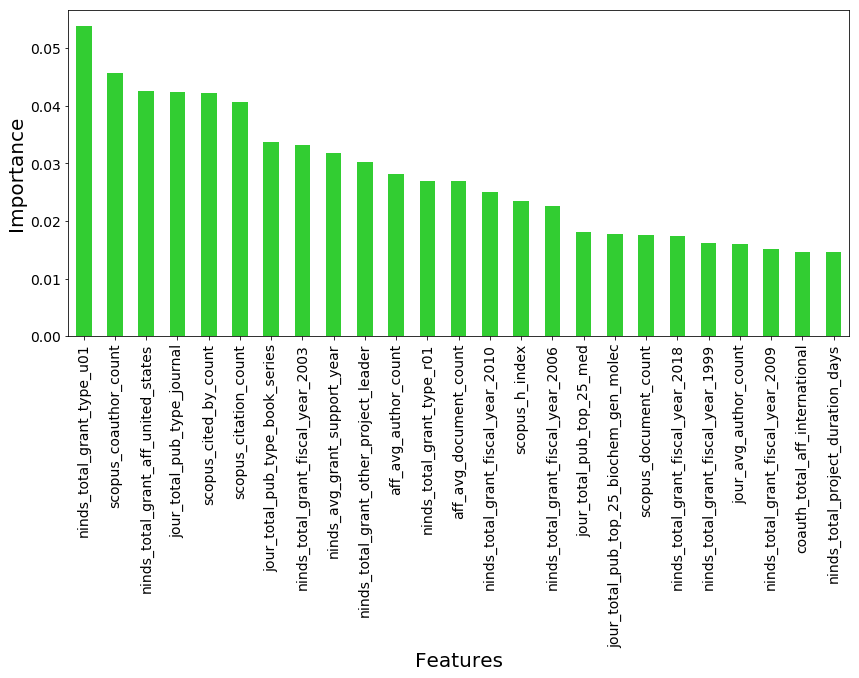

In [12]:
# Random forest classifier
pipe_rfc = Pipeline([('StandardScaler', StandardScaler()), ('RandomForestClassifier', RandomForestClassifier(random_state=0))])

pipe_rfc.fit(X_class, y_class)

important_features_rfc = pd.Series(pipe_rfc.named_steps['RandomForestClassifier'].feature_importances_, features_class)
important_features_rfc = important_features_rfc.sort_values(ascending=False)[0:25]

ax=plt.subplot()
important_features_rfc.plot(x='Feature', y='Importance', kind='bar', figsize=(14,6), color='limegreen', fontsize=14, rot=90, ax=ax)
ax.set_xlabel('Features', fontsize=20)
ax.set_ylabel('Importance', fontsize=20)
plt.show()

In [13]:
# Hyperparameter tune random forest classifier
clfs = {'rfc': RandomForestClassifier(random_state=0)}

pipe_clfs = {}
for name, clf in clfs.items():
    pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), ('clf', clf)])

param_grids = {}
param_grid = [{'clf__n_estimators': [2, 10, 30],
               'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}]
param_grids['rfc'] = param_grid

best_score_param_estimators = []
for name in pipe_clfs.keys():
    gs = GridSearchCV(estimator=pipe_clfs[name],
                      param_grid=param_grids[name],
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=StratifiedKFold(n_splits=10,
                                         shuffle=True,
                                         random_state=0))
    gs = gs.fit(X_class, y_class)
    best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)
for best_score_param_estimator in best_score_param_estimators:
    print([best_score_param_estimator[0], best_score_param_estimator[1], type(best_score_param_estimator[2].named_steps['clf'])], end='\n\n')

[0.9996932515337423, {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 30}, <class 'sklearn.ensemble.forest.RandomForestClassifier'>]



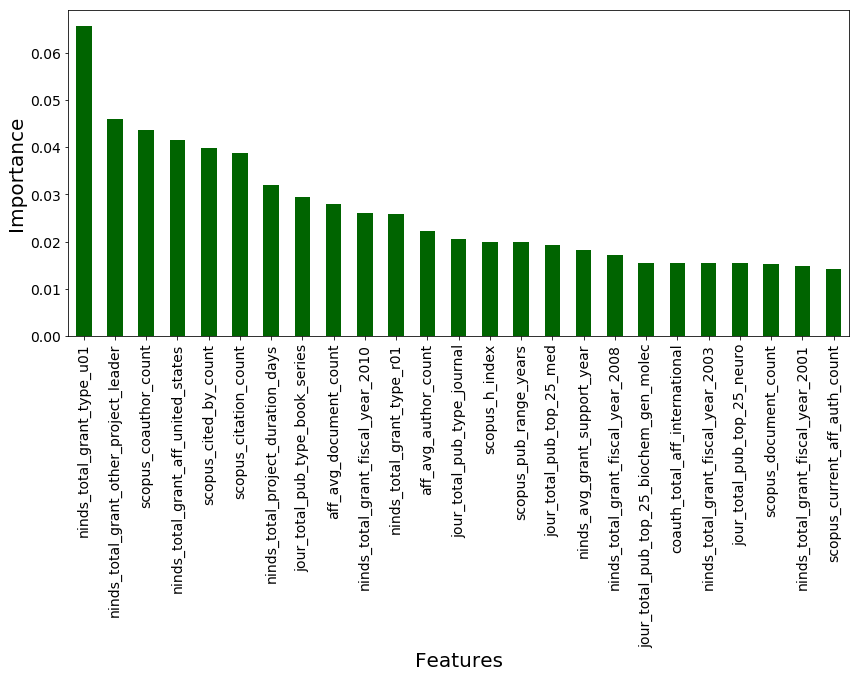

In [14]:
# Plot feature importance based on hyperparameter tuned random forest classifier
pipe_hyp_rfc = Pipeline([('StandardScaler', StandardScaler()), 
                         ('RandomForestClassifier', RandomForestClassifier(min_samples_leaf=1, 
                                                                           min_samples_split=2, 
                                                                           n_estimators=30,
                                                                           random_state=0))])

pipe_hyp_rfc.fit(X_class, y_class)

important_features_hyp_rfc = pd.Series(pipe_hyp_rfc.named_steps['RandomForestClassifier'].feature_importances_, features_class)
important_features_hyp_rfc = important_features_hyp_rfc.sort_values(ascending=False)[0:25]

ax=plt.subplot()
important_features_hyp_rfc.plot(x='Feature', y='Importance', kind='bar', figsize=(14,6), color='darkgreen', fontsize=14, rot=90, ax=ax)
ax.set_xlabel('Features', fontsize=20)
ax.set_ylabel('Importance', fontsize=20)
plt.show()